### The purpose of this notebook to is to recreate the "shelf mask" produced in Amaya et al. (2022)

In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/CTWPC/scripts')
main_dir = "/vortexfs1/home/anthony.meza/CTWPC"
plotsdir = lambda x="": main_dir + "/plots/" + x
GLORYS_dir = lambda x="": main_dir + "/GLORYS_data" + x
GLORYS_process_dir = lambda x="": main_dir + "/GLORYS_processed/" + x

In [2]:
from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
# importlib.reload(xr)
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gsw
from scipy import signal
from scipy import stats

In [3]:
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists

In [4]:
sns.set_context("notebook")

In [5]:
def rm_each_month_mean(ds):
    xy_mean = ds["thetao"].mean(dim=['latitude', 'longitude'], skipna=True)
    z_mean = xy_mean.mean(dim = "depth")
    return xy_mean - z_mean
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies.drop("month")
def remove_daily_climatology(ds):
    climatology = ds.groupby("time.dayofyear").mean("time")
    anomalies = ds.groupby("time.dayofyear") - climatology
    return anomalies.drop("dayofyear")
def remove_season_mean(ds):
    climatology = ds.groupby("time.season").mean("time")
    anomalies = ds.groupby("time.season") - climatology
    return anomalies.drop("season")


In [6]:
%time
from pathlib import Path
from natsort import natsorted
# GLORYS_dir = r"/vortexfs1/home/anthony.meza/GLORYS_data" 
results = [str(result) for result in list(Path(GLORYS_dir()).rglob("*.[nN][cC]"))] #get all files
results = natsorted(results) #sort all files 

years = natsorted(list(set([result[41:45] for result in results])))
months = natsorted(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 5.25 µs


In [7]:
coords_pth = "/vortexfs1/share/cdx/hseo/Data/MERCATOR/GLO-MFC_001_030_coordinates.nc"
bathy_pth = "/vortexfs1/share/cdx/hseo/Data/MERCATOR/GLO-MFC_001_030_mask_bathy.nc"

In [8]:
ikw_Idx = xr.open_dataset("GLORYS_processed/ikw.daily.glorys.1993-2018.nc")
ikw_ssh = xr.open_dataset("GLORYS_processed/ssh.hov.glorys.daily.mean.1993-2018.nc")

In [9]:
ikw_amp = ikw_Idx.ikw_amp.values #t
ikw_ssha = ikw_ssh.ssha_filt_lanc.values #t by space
lats = ikw_ssh.lat_path.values
lons = ikw_ssh.lon_path.values
distances = ikw_ssh.dist_path.values
times = ikw_ssh.time

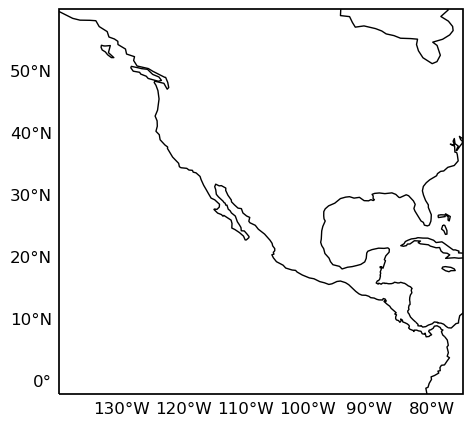

In [10]:
fig,ax = plt.subplots(1, 1, figsize = (25, 5),  subplot_kw = {"projection":ccrs.PlateCarree()})
ax.coastlines()
ax.set_extent([-140, -75, -2, 60], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.0)
gl.top_labels = False
gl.right_labels = False
s = 25
fig.savefig(plotsdir("BlankCalifornia.png"), bbox_inches='tight')
#np.max(np.abs(rs))

In [11]:
from scipy import stats
rs = []
pvals = []

for i in range(0, len(distances)):
    res = stats.pearsonr(ikw_ssha[:, i], ikw_amp)
    rs.append(res.statistic)
    pvals.append(res.pvalue)
    
rs = np.array(rs)
pvals = np.array(pvals)


In [12]:
rs

array([ 0.00803606, -0.00436329, -0.0039399 , ...,  0.02524038,
        0.02520547,  0.02926652])

In [17]:
xr.corr(ikw_ssh.ssha_filt_lanc, ikw_Idx.ikw_amp, dim = "time").values

array([ 0.00803603, -0.00436332, -0.00393995, ...,  0.0252403 ,
        0.02520553,  0.0292665 ])

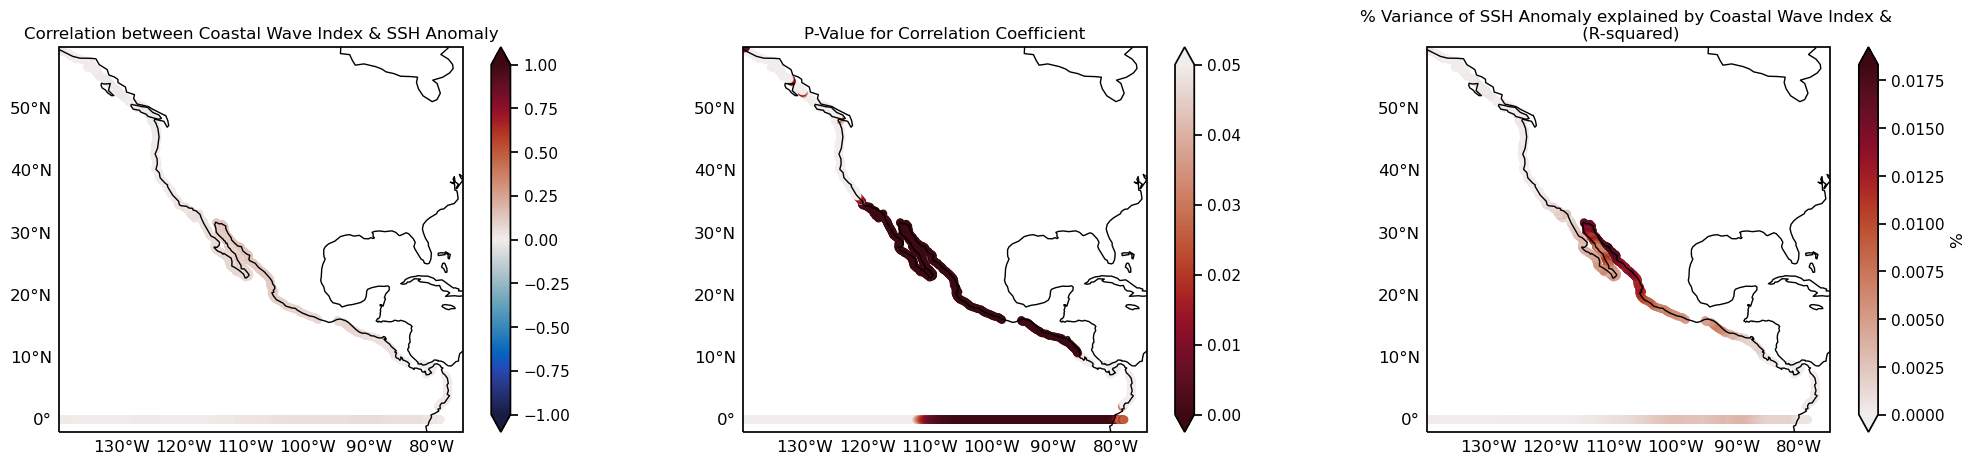

In [67]:
fig,axes = plt.subplots(1, 3, figsize = (25, 5),  subplot_kw = {"projection":ccrs.PlateCarree()})
for ax in axes.flatten():
    ax.coastlines()
    ax.set_extent([-140, -75, -2, 60], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.0)
    gl.top_labels = False
    gl.right_labels = False
s = 25
#np.max(np.abs(rs))
cb = axes[0].scatter(lons, lats, c=rs, vmin=-1, vmax=1, s=s, cmap = cm.balance)
axes[0].set_title("Correlation between Coastal Wave Index & SSH Anomaly")
fig.colorbar(cb, ax=axes[0], orientation='vertical', fraction = 0.04, extend = "both")
cb = axes[1].scatter(lons, lats, c=pvals, vmin=0, vmax=0.05, s=s, cmap = cm.amp_r)

axes[1].set_title("P-Value for Correlation Coefficient")
fig.colorbar(cb, ax=axes[1], orientation='vertical', fraction = 0.04, extend = "both")

cb = axes[2].scatter(lons, lats, c= (rs**2), vmin=0, vmax=np.max((rs**2)), s=s, cmap = cm.amp)
axes[2].set_title("% Variance of SSH Anomaly explained by Coastal Wave Index & \n (R-squared)")
fig.colorbar(cb, ax=axes[2], orientation='vertical', fraction = 0.04, extend = "both", label = "%")
fig.savefig(plotsdir("SSHAnomaly_Amaya_Correlations.png"), bbox_inches='tight')

In [56]:
from scipy import stats
rs = []
pvals = []

for i in range(0, len(distances)):
    res = stats.pearsonr(ikw_ssha[:, i]**2, ikw_amp)
    rs.append(res.statistic)
    pvals.append(res.pvalue)
    
rs = np.array(rs)
pvals = np.array(pvals)


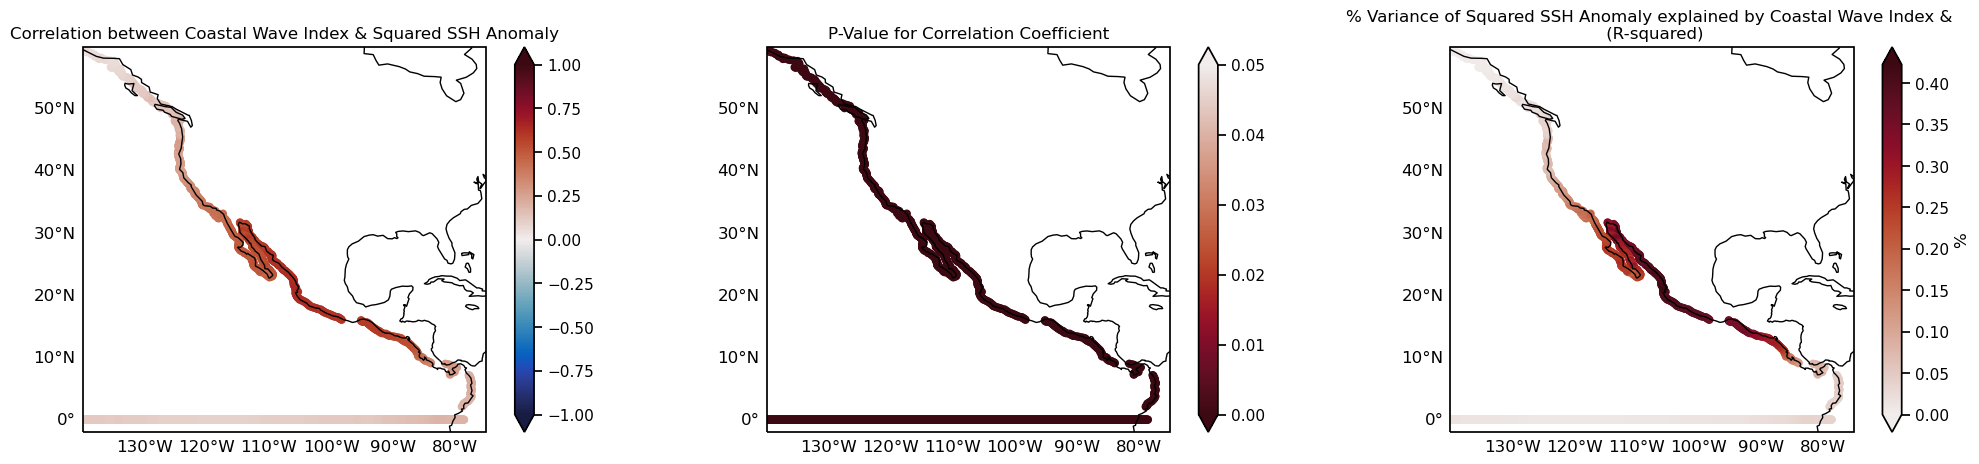

In [57]:
fig,axes = plt.subplots(1, 3, figsize = (25, 5),  subplot_kw = {"projection":ccrs.PlateCarree()})
for ax in axes.flatten():
    ax.coastlines()
    ax.set_extent([-140, -75, -2, 60], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.0)
    gl.top_labels = False
    gl.right_labels = False
s = 25
#np.max(np.abs(rs))
cb = axes[0].scatter(lons, lats, c=rs, vmin=-1, vmax=1, s=s, cmap = cm.balance)
axes[0].set_title("Correlation between Coastal Wave Index & Squared SSH Anomaly")
fig.colorbar(cb, ax=axes[0], orientation='vertical', fraction = 0.04, extend = "both")
cb = axes[1].scatter(lons, lats, c=pvals, vmin=0, vmax=0.05, s=s, cmap = cm.amp_r)

axes[1].set_title("P-Value for Correlation Coefficient")
fig.colorbar(cb, ax=axes[1], orientation='vertical', fraction = 0.04, extend = "both")

cb = axes[2].scatter(lons, lats, c= (rs**2), vmin=0, vmax=np.max((rs**2)), s=s, cmap = cm.amp)
axes[2].set_title("% Variance of Squared SSH Anomaly explained by Coastal Wave Index & \n (R-squared)")
fig.colorbar(cb, ax=axes[2], orientation='vertical', fraction = 0.04, extend = "both", label = "%")
fig.savefig(plotsdir("SquaredSSHAnomaly_Amaya_Correlations.png"), bbox_inches='tight')

In [58]:
def normalize(sig1):
    return (sig1 - np.mean(sig1)) / np.std(sig1)
def xcorr(sig1, sig2):
    nsig1 = normalize(sig1)
    nsig2 = normalize(sig2)
    corr = signal.correlate(nsig1, nsig2)
    lags = signal.correlation_lags(len(nsig1), len(nsig2)) 
    lag = lags[np.argmax(corr)]
    n = len(nsig1) - np.abs(lag)
    return (corr[np.argmax(corr)] / n), lag 

In [59]:
rs = []
lags = []
for i in range(0, len(distances)):
    corr, lag =xcorr(ikw_ssha[:, i]**2, ikw_amp)
    rs.append(corr)
    lags.append(lag)
    # pvals.append(res.pvalue)
rs = np.array(rs)
lags = np.array(lags)


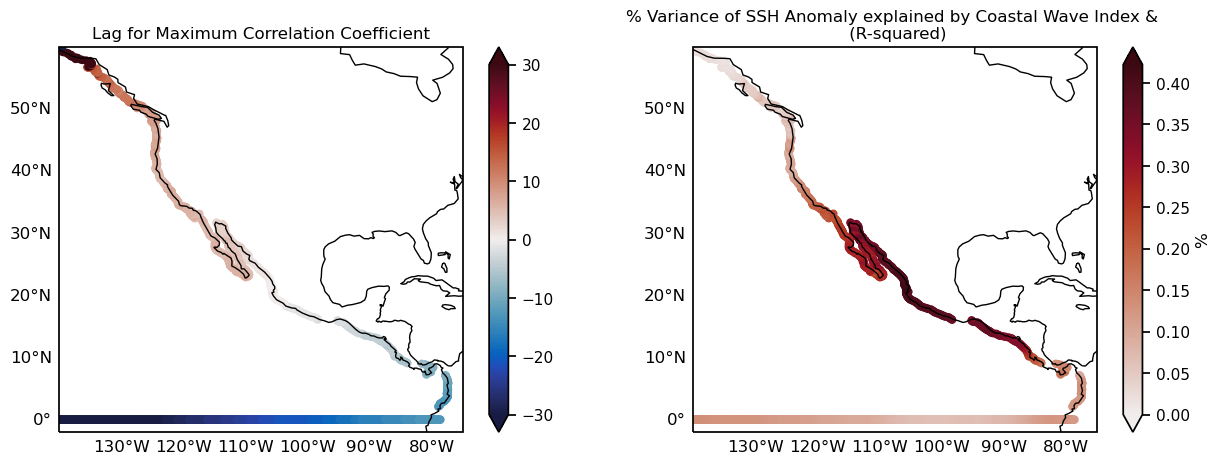

In [60]:
fig,axes = plt.subplots(1, 2, figsize = (15, 5), 
                        subplot_kw = {"projection":ccrs.PlateCarree()})

for ax in axes.flatten():
    ax.coastlines()
    ax.set_extent([-140, -75, -2, 60], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.0)
    gl.top_labels = False
    gl.right_labels = False
s = 25
#np.max(np.abs(rs))

cb = axes[0].scatter(lons, lats, c=lags, vmin=-30, vmax=30, s=s, cmap = cm.balance)
axes[0].set_title("Lag for Maximum Correlation Coefficient")
fig.colorbar(cb, ax=axes[0], orientation='vertical', fraction = 0.04, extend = "both")

cb = axes[1].scatter(lons, lats, c= (rs**2), vmin=0, vmax=np.max((rs**2)), s=s, cmap = cm.amp)
axes[1].set_title("% Variance of SSH Anomaly explained by Coastal Wave Index & \n (R-squared)")
fig.colorbar(cb, ax=axes[1], orientation='vertical', fraction = 0.04, extend = "both", label = "%")
fig.savefig(plotsdir("SquaredSSHAnomaly_Amaya_LaggedCorrelations.png"), bbox_inches='tight')

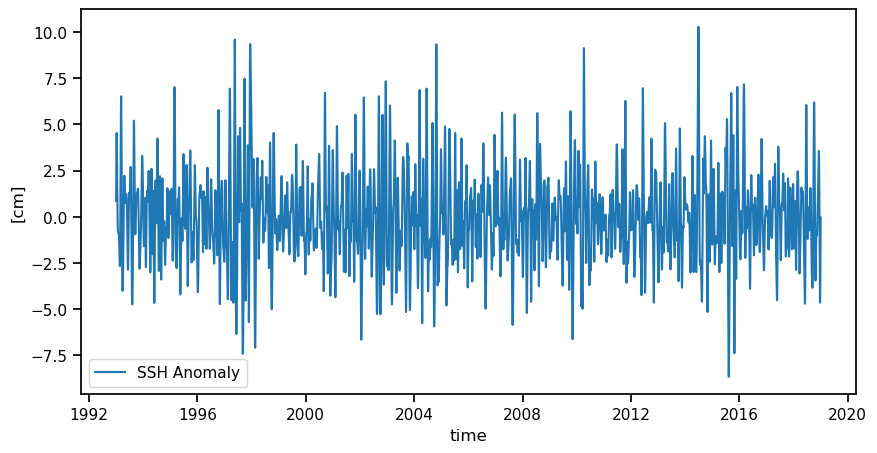

In [61]:
fig,axes = plt.subplots(figsize = (10, 5))
idx = np.argmin(np.abs(lats - 30))
axes.plot(times, ikw_ssha[:, idx], label = "SSH Anomaly"); 
axes.set_xlabel("time"); axes.set_ylabel("[cm]")
axes.legend()
fig.savefig(plotsdir("SSHAnomaly_Amaya.png"), bbox_inches='tight')

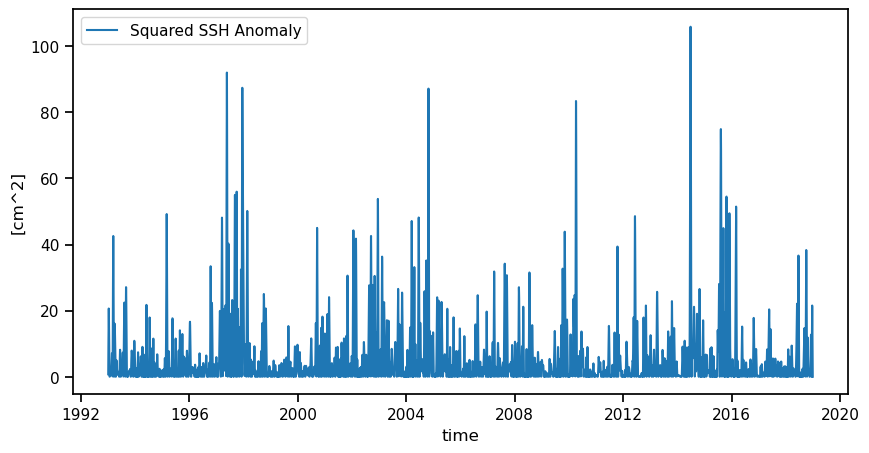

In [62]:
fig,axes = plt.subplots(figsize = (10, 5))
axes.plot(times, ikw_ssha[:, idx]**2, label = "Squared SSH Anomaly"); 
axes.set_xlabel("time"); axes.set_ylabel("[cm^2]")
axes.legend()
fig.savefig(plotsdir("SquaredSSHAnomaly_Amaya.png"), bbox_inches='tight')

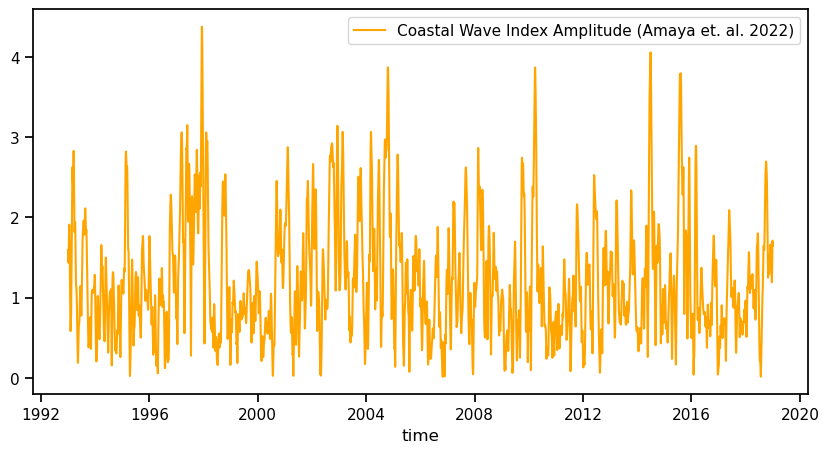

In [65]:
fig,axes = plt.subplots(figsize = (10, 5))
axes.plot(times, ikw_amp,  c = "orange", label = "Coastal Wave Index Amplitude (Amaya et. al. 2022)")
axes.set_xlabel("time"); axes.set_ylabel("")
axes.legend()
fig.savefig(plotsdir("Index_Amaya.png"), bbox_inches='tight')

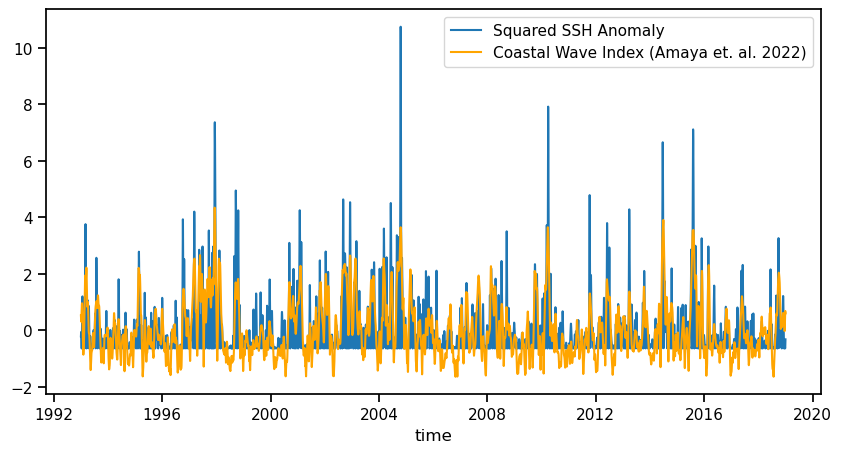

In [54]:
fig,axes = plt.subplots(figsize = (10, 5))
idx = np.argmin(np.abs(lats - 20))
axes.plot(times, normalize(ikw_ssha[:, idx]**2), label = "Squared SSH Anomaly"); 
axes.plot(times, normalize(ikw_amp),  c = "orange", label = "Coastal Wave Index (Amaya et. al. 2022)")
axes.set_xlabel("time"); axes.set_ylabel("")
axes.legend()
fig.savefig(plotsdir("SquaredSSHAnomalyIndex_Amaya.png"), bbox_inches='tight')

In [18]:
#Plot against ENSO Index 

#Now do SSTA 

#Relate SSTA to SSH with simple model 
